In [1]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 32 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (29.8 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5

In [0]:
import glob
import os
import random
import sys
import random
import re
import math
import json
import imutils
from collections import defaultdict
from google.colab.patches import cv2_imshow
import cv2
from PIL import Image, ImageDraw
import numpy as np
from scipy.ndimage.filters import rank_filter
import pytesseract as tes

In [0]:
def dilate(ary, N, iterations): 
    """Dilate using an NxN '+' sign shape. ary is np.uint8."""
    kernel = np.zeros((N,N), dtype=np.uint8)
    kernel[(N-1)//2,:] = 1
    dilated_image = cv2.dilate(ary / 255, kernel, iterations=iterations)

    kernel = np.zeros((N,N), dtype=np.uint8)
    kernel[:,(N-1)//2] = 1
    dilated_image = cv2.dilate(dilated_image, kernel, iterations=iterations)
    return dilated_image


def props_for_contours(contours, ary):
    """Calculate bounding box & the number of set pixels for each contour."""
    c_info = []
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        c_im = np.zeros(ary.shape)
        cv2.drawContours(c_im, [c], 0, 255, -1)
        c_info.append({
            'x1': x,
            'y1': y,
            'x2': x + w - 1,
            'y2': y + h - 1,
            'sum': np.sum(ary * (c_im > 0))/255
        })
    return c_info


def union_crops(crop1, crop2):
    """Union two (x1, y1, x2, y2) rects."""
    x11, y11, x21, y21 = crop1
    x12, y12, x22, y22 = crop2
    return min(x11, x12), min(y11, y12), max(x21, x22), max(y21, y22)


def intersect_crops(crop1, crop2):
    x11, y11, x21, y21 = crop1
    x12, y12, x22, y22 = crop2
    return max(x11, x12), max(y11, y12), min(x21, x22), min(y21, y22)


def crop_area(crop):
    x1, y1, x2, y2 = crop
    return max(0, x2 - x1) * max(0, y2 - y1)


def find_border_components(contours, ary):
    borders = []
    area = ary.shape[0] * ary.shape[1]
    for i, c in enumerate(contours):
        x,y,w,h = cv2.boundingRect(c)
        if w * h > 0.5 * area:
            borders.append((i, x, y, x + w - 1, y + h - 1))
    return borders


def angle_from_right(deg):
    return min(deg % 90, 90 - (deg % 90))


def remove_border(contour, ary):
    """Remove everything outside a border contour."""
    # Use a rotated rectangle (should be a good approximation of a border).
    # If it's far from a right angle, it's probably two sides of a border and
    # we should use the bounding box instead.
    c_im = np.zeros(ary.shape)
    r = cv2.minAreaRect(contour)
    degs = r[2]
    if angle_from_right(degs) <= 10.0:
        box = cv2.boxPoints(r)
        box = np.int0(box)
        cv2.drawContours(c_im, [box], 0, 255, -1)
        cv2.drawContours(c_im, [box], 0, 0, 4)
    else:
        x1, y1, x2, y2 = cv2.boundingRect(contour)
        cv2.rectangle(c_im, (x1, y1), (x2, y2), 255, -1)
        cv2.rectangle(c_im, (x1, y1), (x2, y2), 0, 4)

    return np.minimum(c_im, ary)


def find_components(edges, max_components=16):
    """Dilate the image until there are just a few connected components.
    Returns contours for these components."""
    # Perform increasingly aggressive dilation until there are just a few
    # connected components.
    count = 21
    dilation = 5
    n = 1
    while count > 16:
        n += 1
        dilated_image = dilate(edges, N=3, iterations=n)
        #cv2_imshow(dilated_image)
        #dilated_image=cv2.cvtColor(dilated_image,cv2.COLOR_BGR2GRAY)
        dilated_image=np.array(dilated_image,np.uint8)
        contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        count = len(contours)
    #print dilation
    #Image.fromarray(edges).show()
    #Image.fromarray(255 * dilated_image).show()
    return contours


def find_optimal_components_subset(contours, edges):
    """Find a crop which strikes a good balance of coverage/compactness.
    Returns an (x1, y1, x2, y2) tuple.
    """
    c_info = props_for_contours(contours, edges)
    c_info.sort(key=lambda x: -x['sum'])
    total = np.sum(edges) / 255
    area = edges.shape[0] * edges.shape[1]

    c = c_info[0]
    del c_info[0]
    this_crop = c['x1'], c['y1'], c['x2'], c['y2']
    crop = this_crop
    covered_sum = c['sum']

    while covered_sum < total:
        changed = False
        recall = 1.0 * covered_sum / total
        prec = 1 - 1.0 * crop_area(crop) / area
        f1 = 2 * (prec * recall / (prec + recall))
        #print '----'
        for i, c in enumerate(c_info):
            this_crop = c['x1'], c['y1'], c['x2'], c['y2']
            new_crop = union_crops(crop, this_crop)
            new_sum = covered_sum + c['sum']
            new_recall = 1.0 * new_sum / total
            new_prec = 1 - 1.0 * crop_area(new_crop) / area
            new_f1 = 2 * new_prec * new_recall / (new_prec + new_recall)

            # Add this crop if it improves f1 score,
            # _or_ it adds 25% of the remaining pixels for <15% crop expansion.
            # ^^^ very ad-hoc! make this smoother
            remaining_frac = c['sum'] / (total - covered_sum)
            new_area_frac = 1.0 * crop_area(new_crop) / crop_area(crop) - 1
            if new_f1 > f1 or (
                    remaining_frac > 0.25 and new_area_frac < 0.15):
                crop = new_crop
                covered_sum = new_sum
                del c_info[i]
                changed = True
                break

        if not changed:
            break

    return crop


def pad_crop(crop, contours, edges, border_contour, pad_px=15):
    """Slightly expand the crop to get full contours.
    This will expand to include any contours it currently intersects, but will
    not expand past a border.
    """
    bx1, by1, bx2, by2 = 0, 0, edges.shape[0], edges.shape[1]
    if border_contour is not None and len(border_contour) > 0:
        c = props_for_contours([border_contour], edges)[0]
        bx1, by1, bx2, by2 = c['x1'] + 5, c['y1'] + 5, c['x2'] - 5, c['y2'] - 5

    def crop_in_border(crop):
        x1, y1, x2, y2 = crop
        x1 = max(x1 - pad_px, bx1)
        y1 = max(y1 - pad_px, by1)
        x2 = min(x2 + pad_px, bx2)
        y2 = min(y2 + pad_px, by2)
        return crop
    
    crop = crop_in_border(crop)

    c_info = props_for_contours(contours, edges)
    changed = False
    for c in c_info:
        this_crop = c['x1'], c['y1'], c['x2'], c['y2']
        this_area = crop_area(this_crop)
        int_area = crop_area(intersect_crops(crop, this_crop))
        new_crop = crop_in_border(union_crops(crop, this_crop))
        if 0 < int_area < this_area and crop != new_crop:
            changed = True
            crop = new_crop

    if changed:
        return pad_crop(crop, contours, edges, border_contour, pad_px)
    else:
        return crop


def downscale_image(im, max_dim=2048):
    """Shrink im until its longest dimension is <= max_dim.
    Returns new_image, scale (where scale <= 1).
    """
    a, b = im.size
    if max(a, b) <= max_dim:
        return 1.0, im

    scale = 1.0 * max_dim / max(a, b)
    new_im = im.resize((int(a * scale), int(b * scale)), Image.ANTIALIAS)
    return scale, new_im


def process_image(img,angle):
    orig_im = img
    orig_im=cv2.cvtColor(np.array(orig_im),cv2.COLOR_RGB2BGR)
    orig_im=imutils.rotate_bound(orig_im,angle)
    orig_im=cv2.cvtColor(orig_im,cv2.COLOR_BGR2RGB)
    orig_im=Image.fromarray(orig_im)
    scale, im = downscale_image(orig_im)

    edges = cv2.Canny(np.asarray(im), 100, 200)

    # TODO: dilate image _before_ finding a border. This is crazy sensitive!
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    borders = find_border_components(contours, edges)
    borders.sort(key=lambda x: (x[3] - x[1]) * (x[4] - x[2]))

    border_contour = None
    if len(borders):
        border_contour = contours[borders[0][0]]
        edges = remove_border(border_contour, edges)

    edges = 255 * (edges > 0).astype(np.uint8)

    # Remove ~1px borders using a rank filter.
    maxed_rows = rank_filter(edges, -4, size=(1, 20))
    maxed_cols = rank_filter(edges, -4, size=(20, 1))
    debordered = np.minimum(np.minimum(edges, maxed_rows), maxed_cols)
    edges = debordered
    contours = find_components(edges)
    if len(contours) == 0:
        return

    crop = find_optimal_components_subset(contours, edges)
    crop = pad_crop(crop, contours, edges, border_contour)
    crop = [int(x / scale) for x in crop]  # upscale to the original image size.
    #print(crop)
    im=np.array(orig_im)
    #print(im.shape)
    text_im = orig_im.crop(crop)
    return [text_im,crop]

In [0]:
def process_image_2(img,angle):
    orig_im = img
    orig_im=imutils.rotate_bound(orig_im,angle)
    orig_im=cv2.cvtColor(orig_im,cv2.COLOR_BGR2RGB)
    orig_im=Image.fromarray(orig_im)
    scale, im = downscale_image(orig_im)

    edges = cv2.Canny(np.asarray(im), 100, 200)

    # TODO: dilate image _before_ finding a border. This is crazy sensitive!
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    borders = find_border_components(contours, edges)
    borders.sort(key=lambda x: (x[3] - x[1]) * (x[4] - x[2]))

    border_contour = None
    if len(borders):
        border_contour = contours[borders[0][0]]
        edges = remove_border(border_contour, edges)

    edges = 255 * (edges > 0).astype(np.uint8)

    # Remove ~1px borders using a rank filter.
    maxed_rows = rank_filter(edges, -4, size=(1, 20))
    maxed_cols = rank_filter(edges, -4, size=(20, 1))
    debordered = np.minimum(np.minimum(edges, maxed_rows), maxed_cols)
    edges = debordered
    contours = find_components(edges)
    if len(contours) == 0:
        return

    crop = find_optimal_components_subset(contours, edges)
    crop = pad_crop(crop, contours, edges, border_contour)
    crop = [int(x / scale) for x in crop]  # upscale to the original image size.
    #print(crop)
    im=np.array(orig_im)
    #print(im.shape)
    text_im = orig_im.crop(crop)
    return [text_im,crop]

In [0]:
def get_adhaar_num(txt):
  dit={}
  val=re.findall(r'\d{4} \d{4} \d{4}',txt)
  fadh=""
  mx=0
  for v in val:
    if v not in dit:
      dit[v]=1
    else:
      dit[v]+=1
    if mx<dit[v]:
      fadh=v
  fadh=fadh.split(' ')
  fadh="".join(fadh)
  return [fadh,len(val)]

In [0]:
def mask_number(fadh,boxes,img,crop,shap):
  txt_bx=""
  hi,wi,t=shap
  for b in boxes:
    txt_bx+=b[0]
  dit={}
  iter=re.finditer(fadh,txt_bx)
  r=l=t=d=0
  for i in iter:
    b=boxes[i.start(0)]
    b=b.split()
    l=int(b[1])+crop[0]
    d=(hi-int(b[2]))+crop[1]
    b=boxes[i.start(0)+11]
    b=b.split()
    r=int(b[3])+crop[0]
    t=(hi-int(b[4]))+crop[1]
    b=[l,r,t,d]
    #print(b)
    pts=np.array([[l-5,t-5],[l-5,d+5],[r+5,d+5],[r+5,t-5]],dtype=np.int32)
    img=cv2.fillPoly(img,[pts],color=(0,0,0))
  return img

In [0]:
config = ('-l eng --oem 1 --psm 3')

In [0]:
mx=0
path='drive/My Drive/adr_b/adr_b2.jpg'
angle=[]
p_a=[0,45,90,135,270,360]
img=Image.open(path)
for a in range(0,361,10):
  im,crop=process_image(img,a)
  txt = tes.image_to_string(im,config=config)
  fadh,m=get_adhaar_num(txt)
  if m>mx-1 and m>0:
    mx=m
    angle.append(a)

In [9]:
print(angle)
print(mx)

[180, 270]
1


180
270


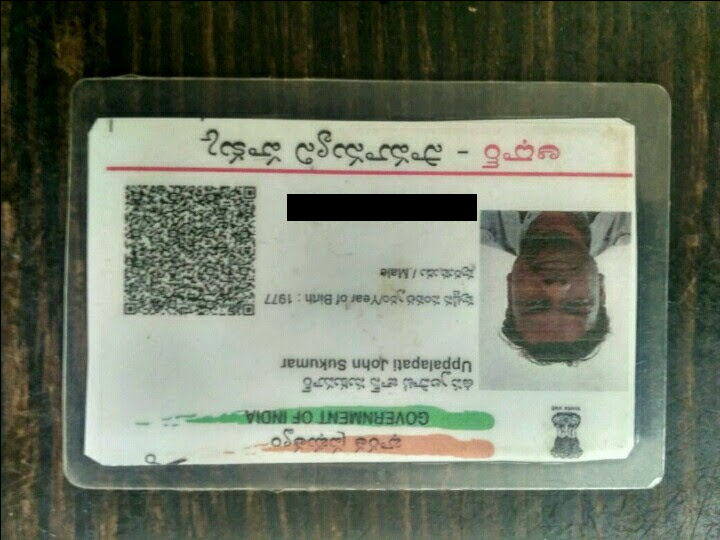

In [10]:
im=img
img=[]
for a in angle:
  txt_im,crop=process_image(im,a)
  im=cv2.cvtColor(np.array(im),cv2.COLOR_RGB2BGR)
  im=imutils.rotate_bound(im,a)

  txt = tes.image_to_string(txt_im,config=config)
  boxes=tes.image_to_boxes(txt_im,config=config)
  boxes=boxes.split('\n')

  txt_im=np.array(txt_im)
  adhaar_num,mx=get_adhaar_num(txt)
  print(a)
  if adhaar_num=="":
    im=img[len(img)-1]
    break
  im=mask_number(adhaar_num,boxes,im,crop,txt_im.shape)
  im=imutils.rotate_bound(im,-1*a)
  img.append(im)
  im=cv2.cvtColor(np.array(im),cv2.COLOR_BGR2RGB)
cv2_imshow(im)